# Deepir implementation
### The code is based on [deepir](https://github.com/TaddyLab/deepir) with slight modification
### Data is based on [Tripadvisor Review](http://www.cs.cmu.edu/~jiweil/html/hotel-review.html)

In [1]:
import re
import json
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

## Preprocessing data 

In [2]:
# all non alphanumeric
contractions = re.compile(r"'|-")
symbols = re.compile(r'(\W+)', re.U)
numeric = re.compile(r'(?<=\s)(\d+|\w\d+|\d+\w)(?=\s)', re.I)
swrd = re.compile(r'(?<=\s)(,|"|\(|\)|to|a|as|the|an|and|or|for|are|is)(?=\s)', re.I)
suffix = re.compile(r'(?<=\w)(s|ings*|ly|(?<=e)[sd]+)(?=\s)')
seps = re.compile(r'\s+')

In [3]:
# cleaner (order matters)
def clean(text): 
    text = u' ' +  text.lower() + u' '
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = numeric.sub('000', text)
    text = swrd.sub(' ', text)
    #text = suffix.sub('', text)
    text = seps.sub(' ', text)
    return text

In [4]:
def preprocess(f_dir):
    data = []
    for line in open(f_dir,'r'):
        d = json.loads(line)
        txt = clean(d['text'])
        data.append([d['ratings']['overall'],txt])
    return pd.DataFrame(data=data,columns=['stars','txt'])

In [5]:
%time tripadvisor_df = preprocess('/home/ruoxu/workspace/data/public/tripadvisor_review/review.txt')

CPU times: user 12min 30s, sys: 5.98 s, total: 12min 36s
Wall time: 12min 36s


In [6]:
tripadvisor_df

,stars,txt
0,5,stayed in king suite 000 nights yes it cots u...
1,5,on every visit nyc hotel beacon place we love...
2,4,this great property in midtown . we two diffe...
3,4,andaz nice hotel in central location of manha...
4,4,i have stayed at each of us andaz properties ...
5,5,excellent staff they remembered our names fro...
6,5,i stayed at setai 000 nights last week my com...
7,5,my husband i stayed at chatwal 000 nights in ...
8,5,wonderful boutique hotel located next times s...
9,4,this hotel nice stay nyc because rooms very c...


In [7]:
from sklearn.cross_validation import train_test_split
train_id, test_id = train_test_split(range(tripadvisor_df.shape[0]),test_size=0.3)
train_df = tripadvisor_df.iloc[train_id]
test_df = tripadvisor_df.iloc[test_id]

In [8]:
train_df.shape,test_df.shape

((614992, 2), (263569, 2))

## Re-write of deepir

In [9]:
import numpy as np
from gensim.models import Word2Vec
from gensim.models import Phrases
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Quadro K2000 (CNMeM is disabled)


In [10]:
# define a review generator
alteos = re.compile(r'( [!\?] )')

def revsplit(l):
    l = alteos.sub(r' \1 . ', l).rstrip("( \. )*\n")
    return [s.split() for s in l.split(" . ")]

def YelpReviews(df):
    data = []
    for star,txt in df.values:
        data.append([star,revsplit(txt)])
    return pd.DataFrame(data=data,columns=['stars','txt'])

In [11]:
%time preprocessed_train_df = YelpReviews(train_df)

CPU times: user 46.4 s, sys: 4.71 s, total: 51.1 s
Wall time: 50.8 s


In [20]:
%time preprocessed_test_df = YelpReviews(test_df)

CPU times: user 24.8 s, sys: 4 s, total: 28.8 s
Wall time: 28.7 s


In [12]:
all_sentences = [s for r in preprocessed_train_df.txt for s in r]
len(all_sentences)

5596213

In [13]:
jointmodel = Word2Vec(workers=-1)
np.random.shuffle(all_sentences)
%time jointmodel.build_vocab(all_sentences)

CPU times: user 49 s, sys: 2.49 s, total: 51.5 s
Wall time: 51.2 s


In [14]:
def trainW2V(g, T=25):
    sent = [l for r in reviews[g] for l in r]
    model[g].min_alpha = model[g].alpha
    for epoch in range(T):
        print epoch, " "
        np.random.shuffle(sent)
        model[g].train(sent)
        model[g].alpha *= 0.9  
        model[g].min_alpha = model[g].alpha  
    print(".")

In [19]:
def getprobs(rev, grp,by = 'average'):
    if by == 'average':
        sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
        eta = pd.DataFrame(
                { g: model[g].score([s for i,s in sentences])  
                 for g in grp } )
        probs = eta.subtract( eta.max('columns'), 'rows') 
        probs = np.exp( probs )
        probs = probs.divide(probs.sum('columns'), "rows")
        probs['cnt'] = 1
        probs = probs.groupby([i for i,s in sentences]).sum()
        probs = probs.divide(probs["cnt"], 'rows').drop("cnt", 1)
    elif by == 'product':
#         sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
#         eta = pd.DataFrame(
#                 { g: model[g].score([s for i,s in sentences])  
#                  for g in grp } )
#         probs = eta.groupby([i for i,s in sentences]).sum()
#         probs = probs.subtract( probs.max('columns'), 'rows')
#         probs = np.exp( probs )
#         probs = probs.divide(probs.sum('columns'), "rows")
        sentences =  [(i,s) for i,r in enumerate(rev) for s in r]
        eta = pd.DataFrame(
                { g: model[g].score([s for i,s in sentences])  
                 for g in grp } )
        probs = eta.groupby([i for i,s in sentences]).sum()
        probs = probs.subtract( probs.min('columns'), 'rows')
        #probs = np.exp( probs )
        probs = probs.divide(probs.sum('columns'), "rows")
        probs.replace([np.inf, -np.inf],0)
        probs.fillna(0)
    return(probs)

### classification by log product probability-- task c

In [16]:
docgrp_fine = {str(i) : i for i in range(0,6)} 
docgrp_fine

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

In [17]:
model = {}
reviews = {}
model = { g: deepcopy(jointmodel) for g in docgrp_fine }
for g in docgrp_fine:
    print g, ":"
    reviews[g] = preprocessed_train_df[preprocessed_train_df['stars']==docgrp_fine[g]].txt
    model[g] = deepcopy(jointmodel)
    trainW2V( g,T=25 )

1 :
0

  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
20

  
21

  
22

  
23

  
24

  
.
0 :
0

  
1  
2  
3  
4

  
5  
6  
7  
8

  
9  
10  
11  
12

  
13  
14  
15  
16

  
17  
18  
19  
20

  
21  
22  
23  
24

  
.
3 :
0

  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
20

  
21

  
22

  
23

  
24

  
.
2 :
0

  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
20

  
21

  
22

  
23

  
24

  
.
5 :
0

  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
20

  
21

  
22

  
23

  
24

  
.
4 :
0

  
1

  
2

  
3

  
4

  
5

  
6

  
7

  
8

  
9

  
10

  
11

  
12

  
13

  
14

  
15

  
16

  
17

  
18

  
19

  
20

  
21

  
22

  
23

  
24

  
.


### Test difference between product and average 

In [21]:
preprocessed_test_df.shape

(263569, 2)

In [22]:
tmp_test_df = preprocessed_test_df[:10000]
groups = ['0','1','2','3','4','5']
prediction_a = getprobs(tmp_test_df.txt.values,groups)
prediction_a['label'] = pd.Series(tmp_test_df.stars.values,index=prediction_a.index)
prediction_a['prediction'] = pd.Series(prediction_a[groups].idxmax('columns').values,index=prediction_a.index).astype(np.float64)
prediction_a['txt'] = pd.Series(tmp_test_df.txt.values,index=prediction_a.index)


prediction_p = getprobs(tmp_test_df.txt.values,groups,by='product')
prediction_p['label'] = pd.Series(tmp_test_df.stars.values,index=prediction_p.index)
prediction_p['prediction'] = pd.Series(prediction_p[groups].idxmax('columns').values,index=prediction_p.index).astype(np.float64)
prediction_p['txt'] = pd.Series(tmp_test_df.txt.values,index=prediction_p.index)

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(prediction_a.prediction.values,prediction_a.label.values)

array([[   0,    0,    0,    5,    0,    3],
       [   0,  481,  301,  163,   67,   32],
       [   0,   73,  153,  170,   64,   13],
       [   0,   30,  194,  534,  347,   74],
       [   0,   12,   61,  432, 1506,  836],
       [   0,   10,   19,  138, 1234, 3048]])

In [27]:
prediction_p=prediction_p.fillna(1)
confusion_matrix(prediction_p.prediction.values,prediction_p.label.values)

array([[   0,    0,    0,    1,    0,    2],
       [   0,  421,  194,   73,   34,   23],
       [   0,  122,  256,  207,   78,   22],
       [   0,   49,  234,  696,  456,  101],
       [   0,   10,   39,  412, 1800, 1034],
       [   0,    4,    5,   53,  850, 2824]])

### Difference with others

 157.408 -254.307 0.850154 23.247 -1.50901854038


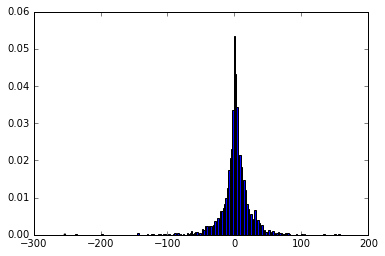

In [29]:
c = 5
from scipy.stats import skew
diff =[]
index = (prediction_a.label == c)
n = 300 #np.where(index)[0].shape[0]
for i in range(n):
    sentences = prediction_a[index].txt.values[i]
    data_others = []
    for g in groups:
        if g != str(c):
            data_others.append(model[g].score(sentences))
    data_others=np.array(data_others)
    data = model[str(c)].score(sentences)
    dif =  data - data_others.max(axis=0)
    diff.append(dif)
diff = np.concatenate(diff)
_=plt.hist(diff,bins=200,normed=True)

print diff.max(),diff.min(),diff.mean(),diff.std(),skew(diff)

164.572 -245.146 -6.29573 18.899 -1.32419621944


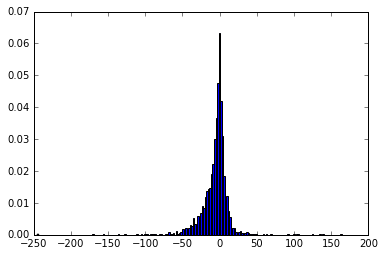

In [30]:
c = 4
from scipy.stats import skew
diff =[]
index = (prediction_a.label == c)
n = 300 #np.where(index)[0].shape[0]
for i in range(n):
    sentences = prediction_a[index].txt.values[i]
    data_others = []
    for g in groups:
        if g != str(c):
            data_others.append(model[g].score(sentences))
    data_others=np.array(data_others)
    data = model[str(c)].score(sentences)
    dif =  data - data_others.max(axis=0)
    diff.append(dif)
diff = np.concatenate(diff)
_=plt.hist(diff,bins=200,normed=True)

print diff.max(),diff.min(),diff.mean(),diff.std(),skew(diff)

164.572 -245.146 -6.29573 18.899 -1.32419621944


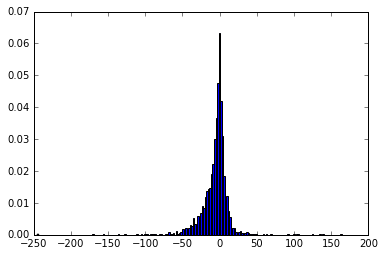

In [31]:
c = 4
from scipy.stats import skew
diff =[]
index = (prediction_a.label == c)
n = 300 #np.where(index)[0].shape[0]
for i in range(n):
    sentences = prediction_a[index].txt.values[i]
    data_others = []
    for g in groups:
        if g != str(c):
            data_others.append(model[g].score(sentences))
    data_others=np.array(data_others)
    data = model[str(c)].score(sentences)
    dif =  data - data_others.max(axis=0)
    diff.append(dif)
diff = np.concatenate(diff)
_=plt.hist(diff,bins=200,normed=True)

print diff.max(),diff.min(),diff.mean(),diff.std(),skew(diff)

79.2646 -209.514 -8.41033 18.4963 -1.80496788025


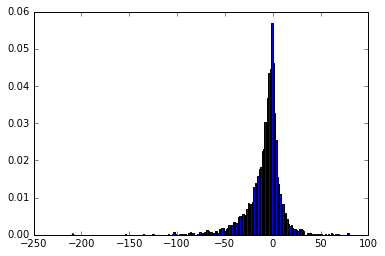

In [32]:
c = 3
from scipy.stats import skew
diff =[]
index = (prediction_a.label == c)
n = 300 #np.where(index)[0].shape[0]
for i in range(n):
    sentences = prediction_a[index].txt.values[i]
    data_others = []
    for g in groups:
        if g != str(c):
            data_others.append(model[g].score(sentences))
    data_others=np.array(data_others)
    data = model[str(c)].score(sentences)
    dif =  data - data_others.max(axis=0)
    diff.append(dif)
diff = np.concatenate(diff)
_=plt.hist(diff,bins=200,normed=True)

print diff.max(),diff.min(),diff.mean(),diff.std(),skew(diff)

86.8306 -597.607 -10.6104 29.5046 -8.94784641266


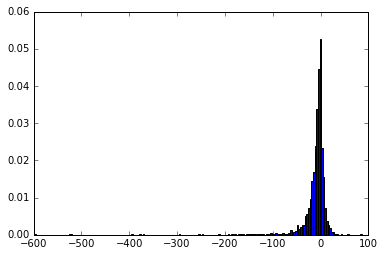

In [33]:
c = 2
from scipy.stats import skew
diff =[]
index = (prediction_a.label == c)
n = 300 #np.where(index)[0].shape[0]
for i in range(n):
    sentences = prediction_a[index].txt.values[i]
    data_others = []
    for g in groups:
        if g != str(c):
            data_others.append(model[g].score(sentences))
    data_others=np.array(data_others)
    data = model[str(c)].score(sentences)
    dif =  data - data_others.max(axis=0)
    diff.append(dif)
diff = np.concatenate(diff)
_=plt.hist(diff,bins=200,normed=True)

print diff.max(),diff.min(),diff.mean(),diff.std(),skew(diff)

580.689 -244.674 1.11285 29.0051 1.71896135807


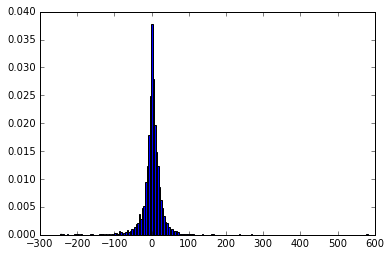

In [34]:
c = 1
from scipy.stats import skew
diff =[]
index = (prediction_a.label == c)
n = 300 #np.where(index)[0].shape[0]
for i in range(n):
    sentences = prediction_a[index].txt.values[i]
    data_others = []
    for g in groups:
        if g != str(c):
            data_others.append(model[g].score(sentences))
    data_others=np.array(data_others)
    data = model[str(c)].score(sentences)
    dif =  data - data_others.max(axis=0)
    diff.append(dif)
diff = np.concatenate(diff)
_=plt.hist(diff,bins=200,normed=True)

print diff.max(),diff.min(),diff.mean(),diff.std(),skew(diff)

(array([ 54.,  31.,  25.,  44.,  53.,  55.,  44.,  28.,   6.,   2.]),
 array([  2.02533073e-25,   7.89983869e-02,   1.57996774e-01,
          2.36995161e-01,   3.15993547e-01,   3.94991934e-01,
          4.73990321e-01,   5.52988708e-01,   6.31987095e-01,
          7.10985482e-01,   7.89983869e-01]),
 <a list of 10 Patch objects>)

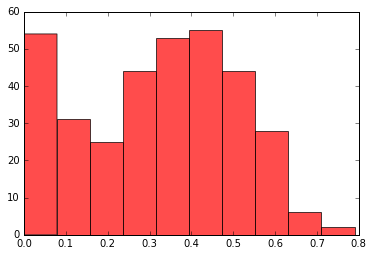

In [136]:
# explore class 5
# average right, product wrong
index_ww = (prediction_a.prediction == prediction_a.label) & (prediction_p.prediction != prediction_p.label)
plt.hist(prediction_a[index_ww]['5'].values,alpha=0.7,color='r')




# plt.figure()
# index_ww = (prediction_a.prediction == prediction_a.label)
# plt.hist(prediction_a[index_ww]['5'].values,alpha=0.7,color='r')

# plt.figure()
# index_ww = (prediction_p.prediction == prediction_p.label)
# plt.hist(prediction_p[index_ww]['5'].values)

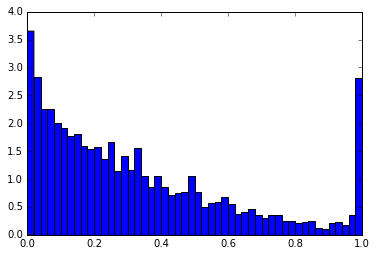

In [179]:
tmp1 = prediction_a[groups]
#tmp1 = (tmp1 - tmp1.values.ravel().mean())/tmp1.values.ravel().std()
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']
plt.figure()
_=plt.hist(tmp1.values,bins=50,normed=True)

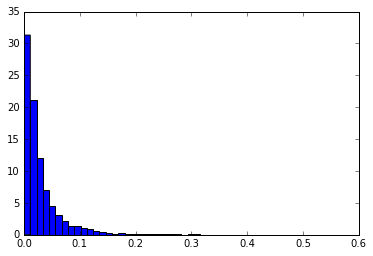

In [190]:
tmp2 = prediction_p[groups]
#tmp2 = (tmp2 - tmp2.values.ravel().mean())/tmp2.values.ravel().std()
tmp2.values.sort(axis=1)
tmp2 = tmp2['5'] - tmp2['4']
plt.figure()
_=plt.hist(tmp2.values,bins=50,normed=True)

(-1, 1)

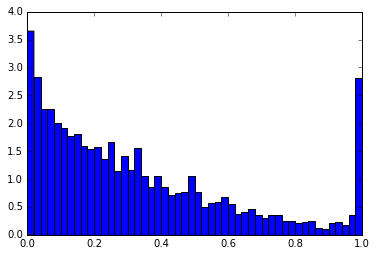

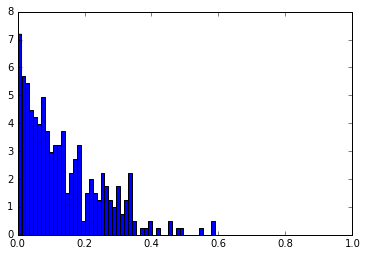

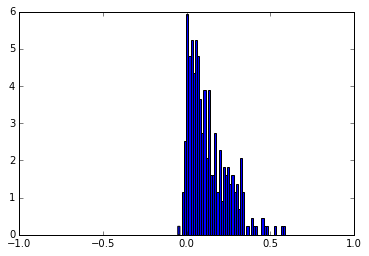

In [188]:
index_ww = (prediction_a.prediction == prediction_a.label) & (prediction_p.prediction != prediction_p.label)
tmp1 = prediction_a[groups]
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']
plt.figure()
plt.hist(tmp1.values,bins=50,normed=True)
#plt.title('Margin of product for all predictions')

tmp1 = prediction_a[index_ww][groups]
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']
plt.figure()
plt.hist(tmp1.values,bins=50,normed=True)
#plt.title('Margin of product for wrong predictions')
plt.xlim((0,1))

tmp1 = prediction_a[index_ww][groups]
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']

tmp2 = prediction_p[index_ww][groups]
tmp2.values.sort(axis=1)
tmp2 = tmp2['5'] - tmp2['4']

plt.figure()
plt.hist(tmp1.values-tmp2.values,bins=50,normed=True)
#plt.title('Difference for margin of average-product in cases where average is right')
plt.xlim(-1,1)

(-1, 1)

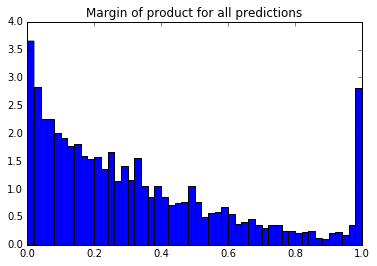

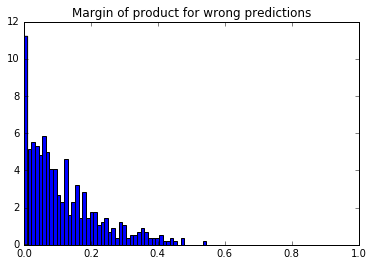

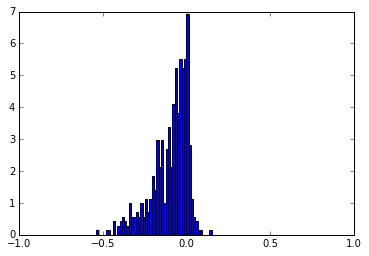

In [189]:
index_ww = (prediction_a.prediction != prediction_a.label) & (prediction_p.prediction == prediction_p.label)
tmp1 = prediction_a[groups]
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']
plt.figure()
plt.hist(tmp1.values,bins=50,normed=True)
plt.title('Margin of product for all predictions')

tmp1 = prediction_a[index_ww][groups]
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']
plt.figure()
plt.hist(tmp1.values,bins=50,normed=True)
plt.title('Margin of product for wrong predictions')
plt.xlim((0,1))

tmp1 = prediction_a[index_ww][groups]
tmp1.values.sort(axis=1)
tmp1 = tmp1['5'] - tmp1['4']

tmp2 = prediction_p[index_ww][groups]
tmp2 = np.exp(tmp2)
tmp2.values.sort(axis=1)
tmp2 = tmp2['5'] - tmp2['4']

plt.figure()
plt.hist(tmp2.values-tmp1.values,bins=50,normed=True)
#plt.title('Difference for margin of average-product in cases where average is right')
plt.xlim(-1,1)